In [1]:
import pandas as pd
import os
from os.path import isfile, join

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt

# pandas display setting
pd.options.display.max_rows = 999

In [2]:
# read file from data folder
datafolder = 'data/'
datafile = 'myo5b_variants_patho_benign_cadd1.3fullannot_v1.xlsx'
datatable = pd.ExcelFile(os.path.join(datafolder,datafile))
datatable_pd = datatable.parse(datatable.sheet_names[0])

# number of features and samples
print(datatable_pd.shape)

# display data
datatable_pd.head()

(248, 117)


,CHROM,POS,ID,REF,ALT,INFO,Type,Length,isTv,isDerived,...,Intron,oAA,nAA,Grantham,PolyPhenCat,PolyPhenVal,SIFTcat,SIFTval,RawScore,PHRED
0,18,47352774,MYO5B:c.5616-2A>G,T,C,Pathogenic,SNV,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334537,6.023
1,18,47361716,MYO5B:c.5392C>T,G,A,Pathogenic,SNV,0,False,True,...,NaN,Q,*,NaN,NaN,NaN,NaN,NaN,14.849415,48.000
2,18,47361725,MYO5B:c.5383C>T,G,A,Pathogenic,SNV,0,False,True,...,NaN,R,*,NaN,NaN,NaN,NaN,NaN,15.701726,52.000
3,18,47365526,MYO5B:c.4840C>T,G,A,Pathogenic,SNV,0,False,True,...,NaN,Q,*,NaN,NaN,NaN,NaN,NaN,14.577744,46.000
4,18,47365610,MYO5B:c.4755_4756dupT,C,CCA,Pathogenic,INS,2,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.553096,35.000


In [14]:
def hist_compare(datatable_pd, col_name):
    '''
    compare the column(col_name) value for different classes
    in the database(datatable_pd) and plot histograms/bar plot 
    for the pathogenic and benign class
    
    currently only support 'Pathogenic' and 'Benign' classes
    no legend in the plot
    '''
    col = datatable_pd[col_name]
    col_patho = col[datatable_pd['INFO']=='Pathogenic']
    col_benig = col[datatable_pd['INFO']=='Benign']
    if datatable_pd[col_name].dtype == np.object:
        x = datatable_pd[col_name].unique()
        y_path = []
        y_beni = []
        for name in x:
            y_name = datatable_pd['INFO'][datatable_pd[col_name]==name]
            y_path.append(y_name[y_name=='Pathogenic'].count())
            y_beni.append(y_name[y_name=='Benign'].count())
        plt.bar(x,y_path,alpha=0.5)
        plt.bar(x,y_beni,alpha=0.5)
    else:
        n,bins,patches = plt.hist(col_patho,50,alpha=0.5)
        n,bins,patches = plt.hist(col_benig,50,alpha=0.5)
    plt.show()

In [4]:
x = datatable_pd.REF.unique()
y_path = []
y_beni = []
for name in x:
    y_name = datatable_pd['INFO'][datatable_pd['REF']==name]
    y_path.append(y_name[y_name=='Pathogenic'].count())
    y_beni.append(y_name[y_name=='Benign'].count())

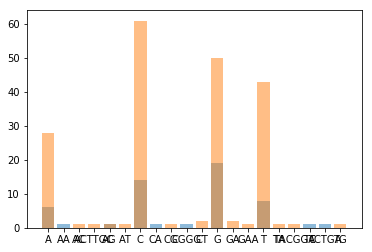

In [5]:
plt.bar(x,y_path,alpha=0.5)
plt.bar(x,y_beni,alpha=0.5)
plt.show()

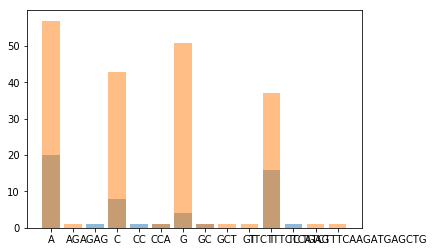

In [16]:
hist_compare(datatable_pd,'ALT')

In [6]:
# display the description for the numerical columns
datatable_num = datatable_pd.select_dtypes(exclude=[np.object])
# exclude the CHROM, POS
des_num = datatable_num[datatable_num.columns.difference(['CHROM', 'POS'])].describe().T
# drop features without any available samples
des_num = des_num.drop(des_num[des_num['count'] < 1].index)
des_num.sort_values(by='count').round(2)

,count,mean,std,min,25%,50%,75%,max
tOverlapMotifs,7.0,4.00,2.24,1.00,2.50,4.00,6.00,6.00
motifDist,7.0,-0.13,0.65,-1.32,-0.39,0.00,0.32,0.53
mirSVR-Aln,18.0,141.44,15.37,120.00,123.25,147.00,154.25,161.00
mirSVR-E,18.0,-12.33,5.04,-24.38,-15.14,-11.92,-9.63,-4.41
mirSVR-Score,18.0,-0.27,0.31,-1.09,-0.31,-0.26,-0.04,-0.01
scoreSegDup,19.0,0.93,0.00,0.93,0.93,0.93,0.93,0.93
TFBS,21.0,3.43,2.93,1.00,1.00,3.00,3.00,11.00
TFBSPeaks,21.0,4.05,3.47,1.00,1.00,3.00,5.00,11.00
TFBSPeaksMax,21.0,57.83,27.67,25.16,36.81,45.93,63.90,105.54
EncOCpolIISig,28.0,0.01,0.02,0.00,0.00,0.00,0.01,0.06


In [7]:
# display the description for columns with object type of values in the table
datatable_obj = datatable_pd.select_dtypes(include=[np.object])
des_obj = datatable_obj.describe()
nr_unique = []
unique =[]
for col_name in datatable_obj.columns:
    nr_unique.append(len(datatable_obj[col_name].unique()))
    unique.append(datatable_obj[col_name].unique())
assert len(nr_unique) == len(des_obj.columns) == len(unique)
des_obj = des_obj.T
des_obj['nr_unique'] = nr_unique
des_obj['unique'] = unique
des_obj

,count,unique,top,freq,nr_unique
ID,248,"[MYO5B:c.5616-2A>G, MYO5B:c.5392C>T, MYO5B:c.5...",PopulationGAVINr0.4,146,103
REF,248,"[T, G, C, AA, A, CGGG, TC, AG, TCTGA, CA, TA, ...",C,75,20
ALT,248,"[C, A, CCA, GC, G, AGAG, CC, T, TC, TGAG, TTCT...",A,77,14
INFO,248,"[Pathogenic, Benign]",Benign,195,2
Type,248,"[SNV, INS, DEL]",SNV,219,3
isTv,218,"[False, nan, True]",False,134,3
AnnoType,248,"[Transcript, CodingTranscript, RegulatoryFeature]",CodingTranscript,189,3
Consequence,248,"[3PRIME_UTR, STOP_GAINED, FRAME_SHIFT, NON_SYN...",NON_SYNONYMOUS,107,10
ConsDetail,248,"[3_prime_UTR, stop_gained,splice, stop_gained,...",missense,102,21
Segway,248,"[R2, F0, R1, TF2, TF0, L0, R4, L1, R3, R0, GE0...",TF0,76,17


In [22]:
# check if there is missing values for RawScore column
datatable_pd['RawScore'].isnull().values.ravel().sum()

0

In [24]:
# columns without any values
null_amount = []
for column in datatable_pd.columns:
    null = datatable_pd[column].isnull().values.ravel().sum()
    if null > 247: # columns without any values
        print(column, null)

targetScan 248
motifECount 248
motifEName 248
motifEHIPos 248
motifEScoreChng 248


In [5]:
# convert all objects in datatable_pd to dummies
categories={} # contains all the levels in those feature columns
categorical_feature_names = [col for col in datatable_pd.select_dtypes(include=[np.object]).columns 
                             if col not in ['INFO','ID','GeneID','FeatureID','GeneName','REF','ALT','CCDS','AnnoType']]
for f in datatable_pd.columns:
    datatable_pd[f] = datatable_pd[f].astype('category')
    categories[f] = datatable_pd[f].cat.categories

new_datatable = pd.get_dummies(datatable_pd,columns=categorical_feature_names)
new_datatable['INFO'] = new_datatable['INFO'].cat.codes

# drop CHROM, POS and etc
new_datatable = new_datatable.drop(columns=['CHROM','POS','ID','GeneID',
                                            'FeatureID','GeneName','REF',
                                            'ALT','CCDS','AnnoType'])

In [21]:
new_datatable.head()

,INFO,Length,isDerived,ConsScore,GC,CpG,mapAbility20bp,mapAbility35bp,scoreSegDup,priPhCons,...,nAA_S,nAA_T,nAA_V,nAA_W,nAA_Y,PolyPhenCat_benign,PolyPhenCat_possibly_damaging,PolyPhenCat_probably_damaging,SIFTcat_deleterious,SIFTcat_tolerated
0,1,0,True,2,0.38,0.00,1.0,1.0,0.93,0.159,...,0,0,0,0,0,0,0,0,0,0
1,1,0,True,8,0.32,0.04,1.0,1.0,NaN,0.908,...,0,0,0,0,0,0,0,0,0,0
2,1,0,True,8,0.32,0.04,1.0,1.0,NaN,0.984,...,0,0,0,0,0,0,0,0,0,0
3,1,0,True,8,0.51,0.07,1.0,1.0,NaN,0.584,...,0,0,0,0,0,0,0,0,0,0
4,1,2,True,7,0.49,0.05,1.0,1.0,NaN,0.993,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# print columns without missing values
null_amount = []
for column in new_datatable.columns:
    null = new_datatable[column].isnull().values.ravel().sum()
    if null > 0:
        print(column, null)

scoreSegDup 229
GerpRS 32
GerpRSpval 32
mirSVR-Score 230
mirSVR-E 230
mirSVR-Aln 230
targetScan 248
EncExp 8
EncOCC 220
EncOCCombPVal 220
EncOCDNasePVal 220
EncOCFairePVal 220
EncOCpolIIPVal 220
EncOCctcfPVal 220
EncOCmycPVal 220
EncOCDNaseSig 220
EncOCFaireSig 220
EncOCpolIISig 220
EncOCctcfSig 220
EncOCmycSig 220
tOverlapMotifs 241
motifDist 241
motifECount 248
motifEName 248
motifEHIPos 248
motifEScoreChng 248
TFBS 227
TFBSPeaks 227
TFBSPeaksMax 227
ESP_AF 214
ESP_AFR 214
ESP_EUR 214
TG_AF 205
TG_ASN 219
TG_AMR 207
TG_AFR 210
TG_EUR 214
cDNApos 40
relcDNApos 40
CDSpos 58
relCDSpos 58
protPos 58
relProtPos 58
Dst2Splice 160
Grantham 141
PolyPhenVal 141
SIFTval 141


In [18]:
# split train and test datasets
train, test = train_test_split(new_datatable,test_size=0.25)
print(train.shape, test.shape)

(186, 258) (62, 258)


In [54]:
# model using SVM with CADD
model_svm = SVC()
model_svm.fit(train['RawScore'].values.reshape(-1,1),train['INFO'])
pred_svm = model_svm.predict(test['RawScore'].values.reshape(-1,1))
tn, fp, fn, tp = confusion_matrix(test['INFO'],pred_svm).ravel()
print('tp fn fp tn\n%d  %d %d  %d'%(tp,fn,fp,tn))
# this model assigns negative to all samples

tp fn fp tn
0  13 0  49


In [14]:
coefficients = pd.concat([pd.DataFrame(train.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)

In [22]:
coefficients.max()

0    verPhyloP_6.334
0           0.553367
dtype: object